# Importowanie niezbędnych bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn import linear_model
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Wczytanie danych, ustawienie rozmiaru obrazów na 64×64 i wyświetlenie przykładowych obrazów

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

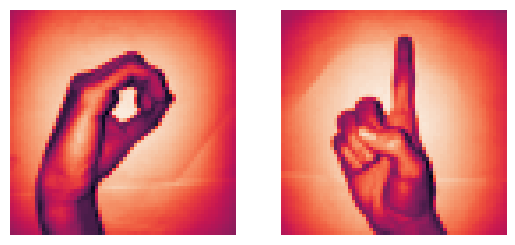

In [2]:
x_l = np.load('X.npy')
y_l = np.load('Y.npy')
img_size = 64
plt.subplot(1, 2, 1)
plt.imshow(x_l[260].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_l[900].reshape(img_size, img_size))
plt.axis('off')

# Połączenie wybranych zakresów obrazów w tablicę X, stworzenie wektora etykiet Y odpowiadającym klasom i wyświetlenie rozmiarów tablic

In [3]:
X = np.concatenate((x_l[204:409], x_l[822:1027]), axis=0)
z = np.zeros(205)
o = np.ones(205)
Y = np.concatenate((z, o), axis=0).reshape(X.shape[0], 1)
print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: (410, 64, 64)
Y shape: (410, 1)


# Podzielenie danych na zestawy treningowy i testowy (15% test), spłaszczenie obrazów z wymiaru 64×64 do wektorów długości 4096 i wyświetlenie nowych rozmiarów tablic.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]
X_train_flatten = X_train.reshape(number_of_train, X_train.shape[1] * X_train.shape[2])
X_test_flatten = X_test.reshape(number_of_test, X_test.shape[1] * X_test.shape[2])
print('X_train flatten:', X_train_flatten.shape)
print('X_test flatten:', X_test_flatten.shape)

X_train flatten: (348, 4096)
X_test flatten: (62, 4096)


# Transpozycja spłaszczonych danych, by kolumny odpowiadały próbom, i wyświetlenie rozmiarów tablic

In [5]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (4096, 348)
x_test shape: (4096, 62)
y_train shape: (1, 348)
y_test shape: (1, 62)


# Funkcja inicjalizującą wagę oraz bias

In [6]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension, 1), 0.01)
    b = 0.0
    return w, b

# Funkcja sigmoidalna służąca jako funkcja aktywacji w regresji logistycznej

In [7]:
def sigmoid(z):
    y_head = 1 / (1 + np.exp(-z))
    return y_head

# Funkcja obliczająca średni koszt w propagacji do przodu

In [8]:
def forward_propagation(w, b, x_train, y_train):
    z = np.dot(w.T, x_train) + b
    y_head = sigmoid(z)
    loss = -y_train * np.log(y_head) - (1 - y_train) * np.log(1 - y_head)
    cost = (np.sum(loss)) / x_train.shape[1]
    return cost

# Funkcja obliczająca średni koszt i gradienty wag i bias w propagacji do przodu i wstecznej

In [9]:
def forward_backward_propagation(w, b, x_train, y_train):
    z = np.dot(w.T, x_train) + b
    y_head = sigmoid(z)
    loss = -y_train * np.log(y_head) - (1 - y_train) * np.log(1 - y_head)
    cost = (np.sum(loss)) / x_train.shape[1]
    
    derivative_weight = (np.dot(x_train, (y_head - y_train).T)) / x_train.shape[1]
    derivative_bias = np.sum(y_head - y_train) / x_train.shape[1]
    gradients = {'derivative_weight': derivative_weight, 'derivative_bias': derivative_bias}
    return cost, gradients

# Aktualizacja wag i bias, wyświetlenie kosztu co 10 kroków i narysowanie wykresu spadku funkcji kosztu

In [10]:
def update(w, b, x_train, y_train, learning_rate, number_of_iterations):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterations):
        cost, gradients = forward_backward_propagation(w, b, x_train, y_train)
        cost_list.append(cost)
        w = w - learning_rate * gradients['derivative_weight']
        b = b - learning_rate * gradients['derivative_bias']
        if i % 10 == 0:
            cost_list2.append(cost)
            index.append(i)
            print(f'Cost after iteration {i}: {cost}')
    
    parameters = {'weight': w, 'bias': b}
    plt.plot(index, cost_list2)
    plt.xticks(index, rotation='vertical')
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost')
    plt.show()
    
    return parameters, gradients, cost_list

# Obliczenie przewidywań i konwersja na etykiety 0 lub 1 na podstawie progu 0.5

In [11]:
def predict(w, b, x_test):
    z = sigmoid(np.dot(w.T, x_test) + b)
    Y_prediction = np.zeros((1, x_test.shape[1]))
    for i in range(z.shape[1]):
        if z[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
    return Y_prediction

# Funkcja regresji logistycznej bazująca na poprzednich funkcjach: inicjalizuje parametry, trenuje model, robi predykcje na zbiorach treningowym i testowym oraz wyświetla ich dokładności

In [12]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate, number_of_iterations):
    dimension = x_train.shape[0]
    w, b = initialize_weights_and_bias(dimension)
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate, number_of_iterations)
    y_prediction_test = predict(parameters['weight'], parameters['bias'], x_test)
    y_prediction_train = predict(parameters['weight'], parameters['bias'], x_train)
    print(f'train accuracy: {100 - np.mean(np.abs(y_prediction_train - y_train)) * 100} %')
    print(f'test accuracy: {100 - np.mean(np.abs(y_prediction_test - y_test)) * 100} %')

# Inicjalizacja wag i bias dla wektora o wymiarze 4096

In [13]:
w, b = initialize_weights_and_bias(4096)
y_head = sigmoid(0)
y_head

np.float64(0.5)

# Uruchomienie spadku gradientu zapisując zwrócone parametry

Cost after iteration 0: 14.014222401929988
Cost after iteration 10: 1.918534888899188
Cost after iteration 20: 1.7503649743452963
Cost after iteration 30: 1.6535238227860236
Cost after iteration 40: 1.560955975593817
Cost after iteration 50: 1.4577445315300086
Cost after iteration 60: 1.3354950822952356
Cost after iteration 70: 1.191800023944936
Cost after iteration 80: 1.0275108866404419
Cost after iteration 90: 0.8430995927556605
Cost after iteration 100: 0.6398899598449164
Cost after iteration 110: 0.43259531532405293
Cost after iteration 120: 0.27819155102645077
Cost after iteration 130: 0.22160871009229446
Cost after iteration 140: 0.20897225691268714
Cost after iteration 150: 0.20341507561975858
Cost after iteration 160: 0.1987537547331435
Cost after iteration 170: 0.19444591698389077
Cost after iteration 180: 0.1904327374402971
Cost after iteration 190: 0.18668325341088549


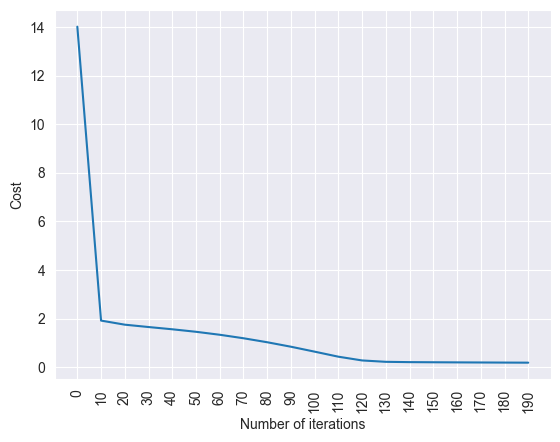

In [14]:
parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate=0.009, number_of_iterations=200)

# Wywołanie funkcji przewidującej, by na podstawie wyuczonych parametrów obliczyć predykcje dla zbioru testowego

In [15]:
predict(parameters['weight'], parameters['bias'], x_test)

array([[0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

# Uruchomienie pełnego przebiegu funkcji regresji logistycznej

Cost after iteration 0: 14.014222401929988
Cost after iteration 10: 2.5446893203484486
Cost after iteration 20: 2.577950409665772
Cost after iteration 30: 2.397998654969697
Cost after iteration 40: 2.1850188570178917
Cost after iteration 50: 1.968348142735899
Cost after iteration 60: 1.7541952211039318
Cost after iteration 70: 1.5350787865532223
Cost after iteration 80: 1.2975667714608898
Cost after iteration 90: 1.0319185565971347
Cost after iteration 100: 0.7370191671189027
Cost after iteration 110: 0.44135512752359
Cost after iteration 120: 0.252277761809715
Cost after iteration 130: 0.2051681344185774
Cost after iteration 140: 0.19616756380442574


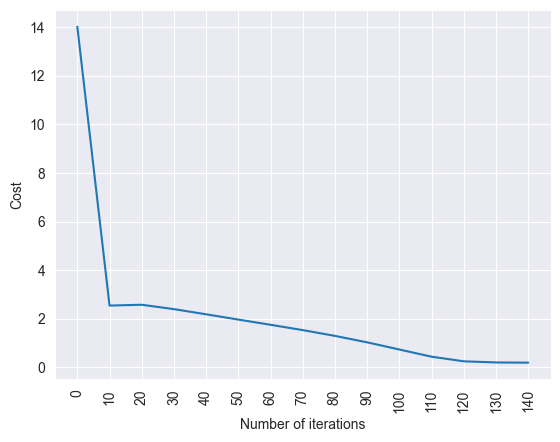

train accuracy: 92.816091954023 %
test accuracy: 93.54838709677419 %


In [16]:
logistic_regression(x_train, y_train, x_test, y_test, learning_rate=0.01, number_of_iterations=150)

# Porównanie implementacji własnej z gotową klasą LogisticRegression ze scikit-learn

In [17]:
logreg = linear_model.LogisticRegression(random_state=42, max_iter=150)
print(f'test accuracy: {logreg.fit(x_train.T, y_train.T).score(x_test.T, y_test.T)}')
print(f'train accuracy: {logreg.fit(x_train.T, y_train.T).score(x_train.T, y_train.T)}')

test accuracy: 0.967741935483871
train accuracy: 1.0
